#### Подготовка среды

In [1]:
import json
from typing import List

import numpy as np
from joblib import Parallel, delayed

from time_series import TimeSeries
from user_interface import InputParams, process_cli

In [2]:
def get_files_names(params: InputParams) -> List[str]:
    """
    Возвращает список имён файлов с данными
    """
    if params.tickets_group:
        with open('configuration.json', 'r') as file:
            configuration = json.load(file)
        return configuration['tickets_groups'][params.tickets_group]
    else:
        return params.files_names

def process_ts(file_name: str, time_series_params: dict) -> TimeSeries:
    """
    Обработка одного временного ряда
    time_series_params — словарь параметров для обработки временного ряда
    """
    ts = TimeSeries(file_name=file_name, **time_series_params)
    ts.process()
    return ts


def train_ts_model(ts: TimeSeries, train_ratio: float, n_runs: int) -> TimeSeries:
    """
    Создание моделей временного ряда
    """
    ts.rolling_models(train_ratio = train_ratio, n_runs = n_runs)
    return ts

#### Начало обработки данных

In [3]:
params = InputParams(
    directory = 'data',
    files_names = None,
    tickets_group = 'NDXT_30',
    file_extension = 'csv',
    time_column = 'date',
    processed_columns = ['open', 'close'],
    target_frequency = 'H',
    frequency_method = 'mean',
    missing_method = 'rolling',
    anomaly_method = 'rolling',
    rolling_window = 2,
    z_threshold = 3.0,
    decompose_model = 'additive',
    decompose_period = 24*7*4 # дискретизация тренда по месяцам при условии наличия часовых наблюдений
)

In [4]:
files_names = get_files_names(params)

time_series_params = dict(
    directory=params.directory,
    file_extension=params.file_extension,
    time_column=params.time_column,
    processed_columns=params.processed_columns,
    target_frequency=params.target_frequency,
    frequency_method=params.frequency_method,
    missing_method=params.missing_method,
    anomaly_method=params.anomaly_method,
    rolling_window=params.rolling_window,
    z_threshold=params.z_threshold,
    decompose_model=params.decompose_model,
    decompose_period=params.decompose_period
)

In [5]:
# Параллельная обработка временных рядов
time_series: List[TimeSeries] = Parallel(n_jobs=-1, backend='threading', verbose=10)(
    delayed(process_ts)(file_name, time_series_params)
    for file_name in files_names
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    4.9s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    7.8s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    8.5s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    9.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    9.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.9s finished


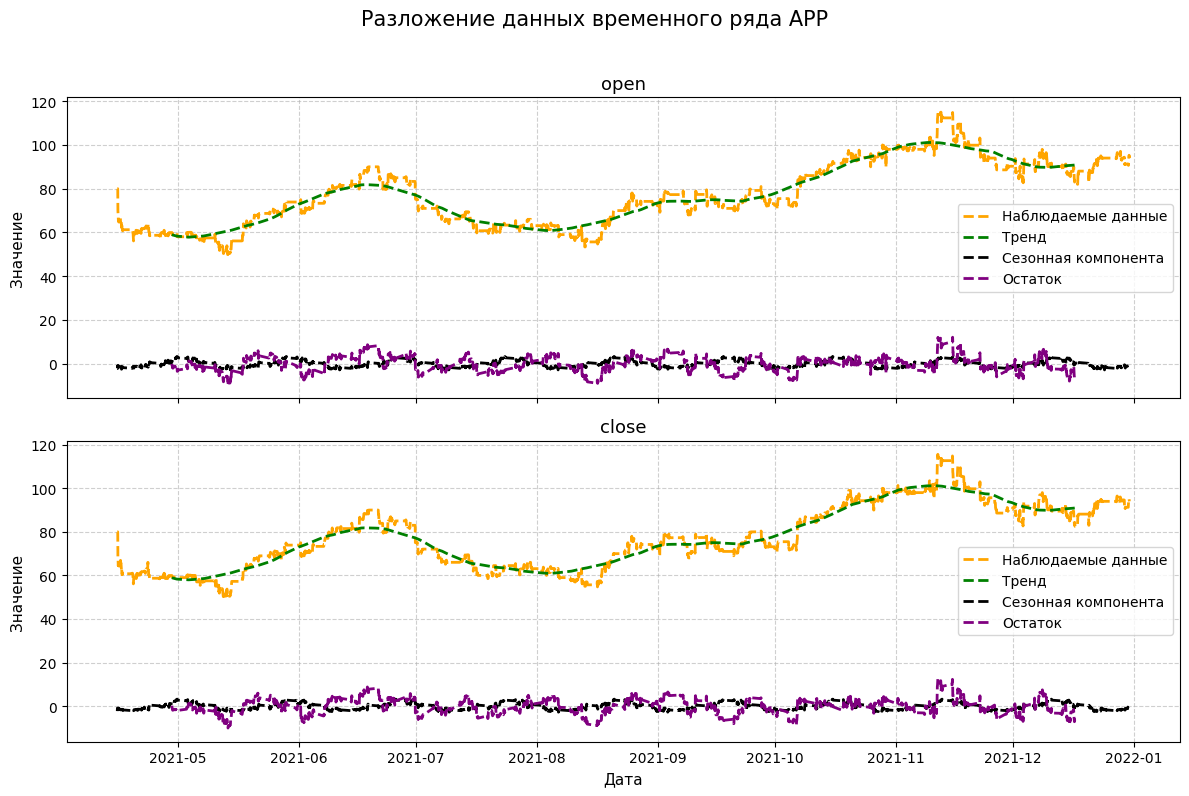

In [6]:
# После обработки визуализируем один тикет
for ts in time_series:
    if ts.file_name == 'APP':
        ts.show()

In [7]:
# Набор данных для примера
for ts in time_series:
    if ts.file_name == 'APP':
        example_ts = ts
# Выводим обработанные данные категории open одного тикета
example_ts.data_processed_columns['open'].style

In [8]:
# Параллельное создание 10 моделей временных рядов
time_series: List[TimeSeries] = Parallel(n_jobs=-1, backend='threading', verbose=10)(
    delayed(train_ts_model)(ts=ts, train_ratio=0.9, n_runs=10)
    for ts in time_series
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   48.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.0min remaining:   36.3s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.3min remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.4min remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


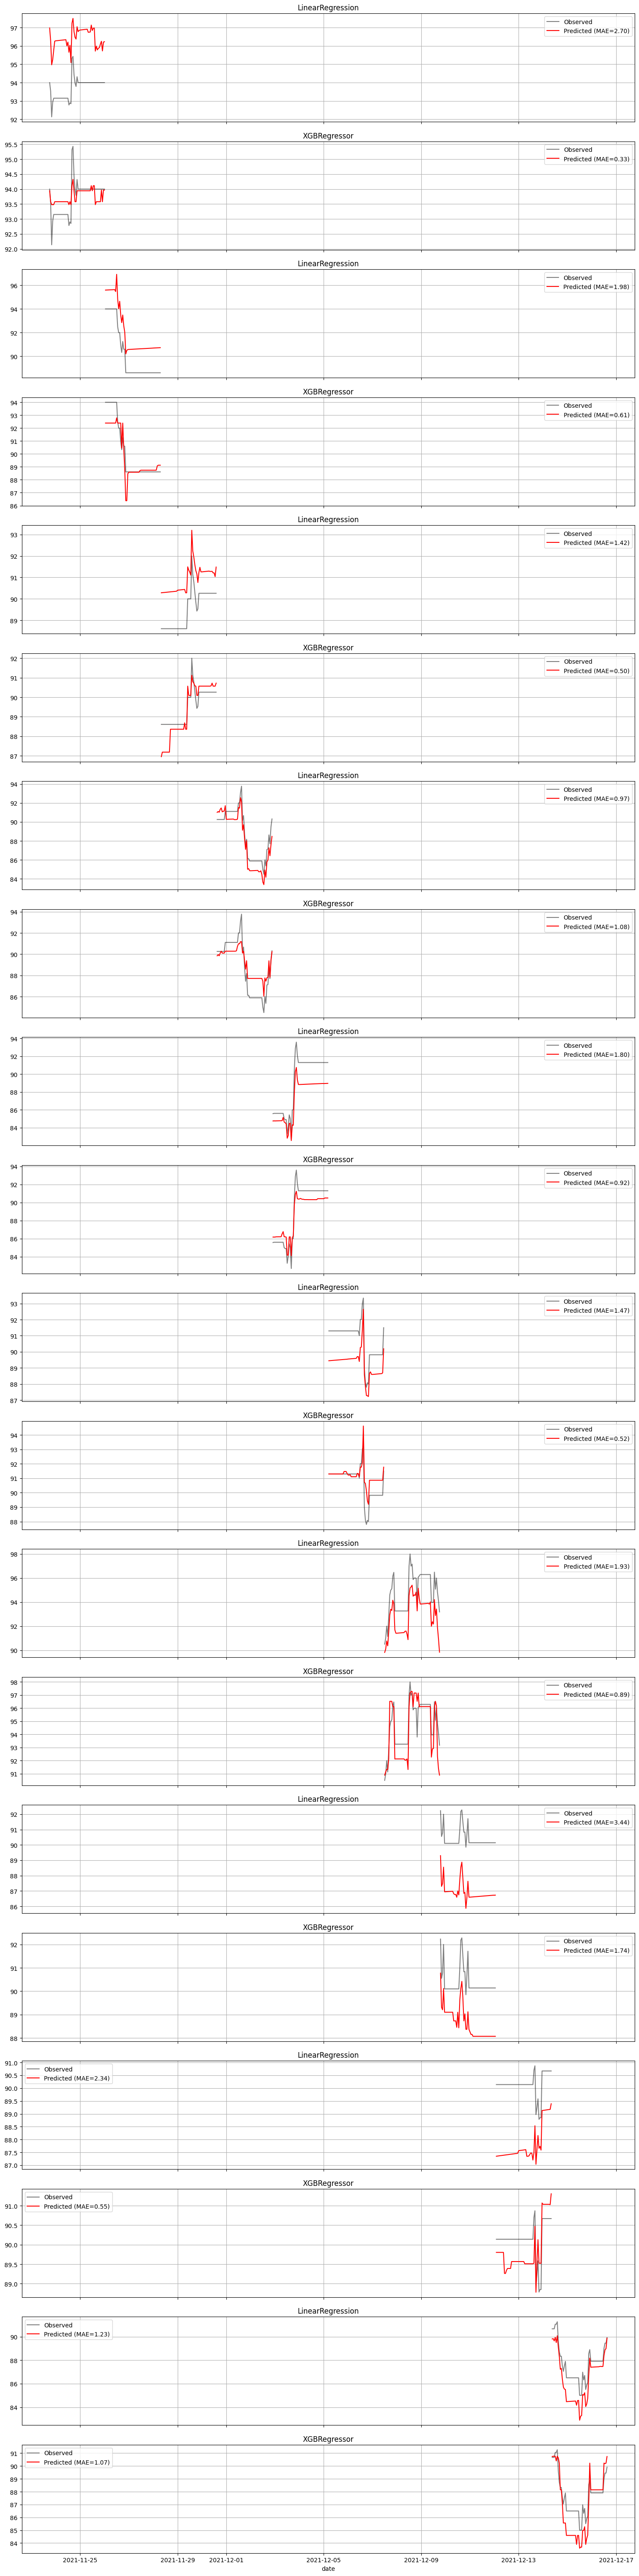

In [9]:
# Набор данных для примера
for ts in time_series:
    if ts.file_name == 'APP':
        example_ts = ts
# Выводим значение метрики MAE для 10 моделей
example_ts.show_metric(column_name = 'open', metric_name = 'MAE')